In [27]:
import numpy as np
import pandas as pd
from scipy import stats 
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [2]:
plt.style.use('ggplot')
%matplotlib inline

### Доверительный интервал для ожидания

In [ ]:
center = d['feature'].mean()
se = d['feature'].std(ddof = 1) / np.sqrt(len(d['feature']))

stats.norm.interval(0.95, loc=center, scale=se)

### Доверительный интервал для разницы ожиданий (без предположения о равенстве дисперсий)

In [ ]:
center = x.mean() - y.mean()
se = np.sqrt(x.var(ddof = 1) / len(x) + y.var(ddof = 1) / len(y))

stats.norm.interval(0.95, loc=center, scale=se) # асимптотический

In [ ]:
stats.ttest_ind(x, y, equal_var=False, nan_policy='omit') # Уэлча

### Симуляция распределений

In [3]:
n_exp = 10 ** 6
n_obs = 200

Включаем логику: от экспериментов нам нужно только выборочное среднее и оценка дисперсии :)

$\bar X \sim N(0,\, 1/n)$, $\bar Y \sim N(0,\, 2/n)$

In [7]:
wp = pd.DataFrame({'xbar': stats.norm.rvs(loc=0, scale=np.sqrt(1 / n_obs), size=n_exp),'ybar': stats.norm.rvs(loc=0, scale=np.sqrt(2 / n_obs), size=n_exp)})

Продолжаем логику:
$\hat \sigma^2  \sim \chi^2_{n-1} * \sigma^2 / (n - 1)$

In [8]:
wp['xvar'] = stats.chi2.rvs(df = n_obs-1, size = n_exp) * 1 / (n_obs - 1)
wp['yvar'] = stats.chi2.rvs(df = n_obs-1, size = n_exp) * 2 / (n_obs - 1)

In [9]:
wp['f_stat'] = wp['xvar'] / wp['yvar']

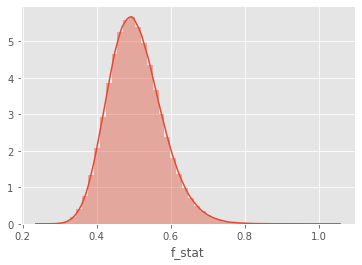

In [10]:
sns.distplot(wp['f_stat'])

In [13]:
f_crit_left = stats.f.ppf(0.025, dfn = n_obs-1, dfd = n_obs-1)
f_crit_right = stats.f.ppf(0.975, dfn = n_obs-1, dfd = n_obs-1)
f_crit_left, f_crit_right

(0.7567865925173471, 1.3213764750689314)

Если гипотеза о равенстве дисперсий не отвергается, то используем $t$-статистику для проверки гипотезы о равенстве ожиданий при равенстве дисперсий.

In [15]:
wp_subset = wp.query('f_stat > @f_crit_left & f_stat < @f_crit_right')
wp_subset.head()

,xbar,ybar,xvar,yvar,f_stat
240,0.062159,-0.139072,1.297022,1.558131,0.832421
272,0.051460,0.055271,1.282082,1.581680,0.810583
2459,0.073788,0.224493,1.282971,1.575264,0.814448
2630,0.021161,-0.096629,1.292831,1.593335,0.811399
2642,0.025593,0.078093,1.081203,1.410399,0.766593


In [21]:
1 - wp_subset.shape[0] / n_exp # доля наблюдений, для которых H0 отвергается

0.998228

In [22]:
wp_subset['sigma_tot'] = np.sqrt(wp_subset['xvar'] * 0.5 + wp_subset['yvar'] * 0.5)
wp_subset['t_stat'] = (wp_subset['xbar'] - wp_subset['ybar']) / wp_subset['sigma_tot'] / np.sqrt(2 / n_obs)


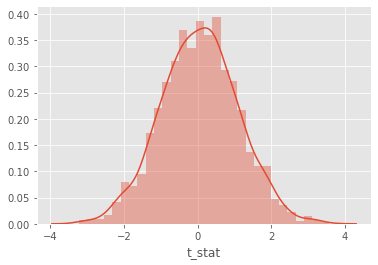

In [23]:
sns.distplot(wp_subset['t_stat'])

In [25]:
t_crit_left = stats.t.ppf(0.025, df=2 * (n_obs - 1))
t_crit_right = - t_crit_left
t_crit_left, t_crit_right

(-1.965942323976193, 1.965942323976193)

In [26]:
wp_sub2 = wp_subset.query('t_stat > @t_crit_left & t_stat < @t_crit_right')
1 - wp_sub2.shape[0] / wp_subset.shape[0]

0.06207674943566588

Эта фактическая вероятность ошибки первого рода похожа на 0.06, а не на 0.05, и это существенное отличие (~20%) вызвано тем, что t-test мы можем использовать когда **дисперсии равны**, а не когда гипотеза о равенстве дисперсий не отвергнута!

### Максимальное правдоподобие

In [28]:
fbock = pd.DataFrame({'y': [3.2, 7.9, 5.4, 4.9, 6.2, 4.3], 
    'ghost': [1, 2, 0, 0, 2, 0]})

Готовый метод максимального правдоподобия для некоторых распределений:

In [30]:
stats.norm.fit(fbock['y']) # hat mu, hat sigma

(5.316666666666666, 1.4803340463857775)

Сделаем руками ML для распределения Пуассона! $ ghost_i \sim Poisson(rate)$

- $ P(ghost_i = k) = \exp(-rate) * \frac{rate^k}{k!} $

- $ ln P(ghost_i = k) = -rate + k \log(rate) - \log(k!) $

Экстремум ищем для $-\theta + k \log(\theta)$, пока что опуская недопустимость перебора $\theta < 0$.

In [40]:
def neg_ell(theta, fbock):
    ln_prob = -theta + fbock['ghost'] * np.log(theta)
    ell = np.sum(ln_prob) # в силу независимости дней
    return -ell

theta_init = 1 

opt_results = minimize(neg_ell, theta_init, args=fbock)
opt_results

      fun: 5.911607783969773
 hess_inv: array([[0.1389374]])
      jac: array([5.96046448e-08])
  message: 'Optimization terminated successfully.'
     nfev: 29
      nit: 5
     njev: 9
   status: 0
  success: True
        x: array([0.83333333])

Чтобы недопустить рассмотрение алгоритмом $\theta < 0$, навесим преобразование $R \to (0; \infty)$

Пусть $\theta = \log(rate)$

In [41]:
def neg_ell(theta, fbock):
    rate = np.exp(theta)
    ln_prob = -rate + fbock['ghost'] * np.log(rate)
    ell = np.sum(ln_prob) # в силу независимости дней
    return -ell

In [42]:
theta_init = -2

opt_results = minimize(neg_ell, theta_init, args=fbock)
opt_results

      fun: 5.911607783969777
 hess_inv: array([[0.20023496]])
      jac: array([2.38418579e-07])
  message: 'Optimization terminated successfully.'
     nfev: 24
      nit: 6
     njev: 8
   status: 0
  success: True
        x: array([-0.18232151])

In [43]:
np.exp(opt_results.x)

array([0.83333337])

### Пуассоновская регрессия

- $rate_i = \exp( \beta_0 + \beta_1 \cdot y_i)$
- $ghost_i \,|\, rate_i \sim Poisson(rate_i)$
- $\theta = (\beta_0, \,\beta_1)$


In [46]:
def neg_ell(theta, fbock):
    a, b = theta
    rate = np.exp(a + b * fbock['y'])
    ln_prob = -rate + fbock['ghost'] * np.log(rate)
    ell = np.sum(ln_prob) # в силу независимости дней
    return -ell

In [47]:
theta_init = [0, 0]

opt_results = minimize(neg_ell, theta_init, args=fbock)
opt_results

      fun: 4.901374802427494
 hess_inv: array([[ 3.65178738, -0.54899458],
       [-0.54899458,  0.08731151]])
      jac: array([5.96046448e-08, 5.96046448e-08])
  message: 'Optimization terminated successfully.'
     nfev: 52
      nit: 9
     njev: 13
   status: 0
  success: True
        x: array([-2.59878438,  0.4169601 ])

Эту модель регрессии можно найти в `statsmodels`.

In [48]:
import statsmodels.formula.api as smf

In [49]:
model = smf.poisson('ghost ~ 1 + y', data=fbock).fit()
model.summary()

Optimization terminated successfully.
         Current function value: 1.047945
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                          Poisson Regression Results                          
==============================================================================
Dep. Variable:                  ghost   No. Observations:                    6
Model:                        Poisson   Df Residuals:                        4
Method:                           MLE   Df Model:                            1
Date:                Mon, 22 Jun 2020   Pseudo R-squ.:                  0.1384
Time:                        11:59:30   Log-Likelihood:                -6.2877
converged:                       True   LL-Null:                       -7.2979
Covariance Type:            nonrobust   LLR p-value:                    0.1552
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.5988      1.918     -1.355      0.175      -6.358       1.161
y              0.4170      0.297      1.404      0.160      -0.165       0.999
==============================================================================
"""